# Project Report (Heart Disease)

### Introduction:

Scientific Question: Does the patient have heart disease or not based on the following factors: age, blood pressure, cholesterol and chest pain type?

Cardiovascular heart disease is one of the leading causes of death worldwide according to the World Health Organization (WHO). However, one of the most difficult tasks in clinical data analysis is to predict a heart disease. Machine learning (ML) is helpful for diagnostic aid in terms of decision-making and prediction based on the data generated by the healthcare sector globally. Therefore, this project aims to use a machine learning algorithm to predict whether or not a patient has heart disease based on age, blood pressure, cholesterol levels, and chest pain type and its degree of accuracy. We will be training the model based on the dataset from https://doi.org/10.24432/C52P4X1. The dataset includes 13 variables from 4 different databases that can help our model identify if a patient is experiencing heart disease by determining if their angiographic narrowing is greater than 50%.


### Preliminary Exploratory Data Analysis
Note that we have imported and built up the data frame and some function in the Jupyter notebook, here are our steps:

**Reading Data**

We directly used the function read_csv with the URL of the data frame (already tidy) on our Github.

By combining all 4 data frames from different countries with r_bind, we get a full data frame including all cases.

Some of the observations are not including certain information, therefore, we use function "filter" to remove these observations, and obtain a clean data frame.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(cowplot)

colnames1 <- c("index", "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
              "slope", "ca", "thal", "num")

colnames2 <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
              "slope", "ca", "thal", "num")

# Reading in the data
cleveland_raw <- read_csv("https://raw.githubusercontent.com/jlieu88/dsci-100-project/main/data/cleveland.csv", col_name = colnames1, , skip = 1)
switzerland_raw <- read_csv("https://raw.githubusercontent.com/jlieu88/dsci-100-project/main/data/switzerland.csv", col_name = colnames1, , skip = 1)
va_raw <- read_csv("https://raw.githubusercontent.com/jlieu88/dsci-100-project/main/data/va_longbeach.csv", col_name = colnames1, , skip = 1)
hungary <- read_csv("https://raw.githubusercontent.com/jlieu88/dsci-100-project/main/data/hungary.csv", col_name = colnames2, skip = 1)


# Selecting the data without the index
cleveland <- select(cleveland_raw, -index)
switzerland <- select(switzerland_raw, -index)
va <- select(va_raw, -index)


# Filtering out the aggregated databases for bad data points
database_raw <- rbind(cleveland, switzerland, va, hungary)
database <- database_raw |>
            filter(age != "?") |>
            filter(sex != "?") |>
            filter(cp != "?") |>
            filter(trestbps != "?") |>
            filter(chol != "?") |>
            filter(fbs != "?") |>
            filter(restecg != "?") |>
            filter(thalach != "?") |>
            filter(exang != "?") |>
            filter(oldpeak != "?") |>
            filter(slope != "?") |>
            filter(ca != "?") |>
            filter(thal != "?") |>
            filter(num != "?") |>
            filter(exang != -9) |>
            filter(fbs != -9) |>
            filter(slope != -9) |>
            filter(ca != -9) |>
            filter(ca != 9) |>
            filter(num != 2) |>
            filter(num != 3) |>
            filter(num != 4) |>
            mutate_if(is.character, as.numeric)

print("Table 1: Fourteen variables from the combined data frames related to heart disease")
# Totally, there are 5 data frames:
# 1. cleveland
# 2. switzerland
# 3. va
# 4. hungary
# 5. database
head(database)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

[1] "Table 1: Fourteen variables from the combined data frames related to heart disease"


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0


**Summarizing data**

The training and testing data are splitted with a proportion of 0.75 and 0.25 from the data frame. Three tables are concluded to summarize the data:

count_age and count_cp, which counts the number of people with different ages and different chest pain types. These 2 tables reflect that we have enough data points from these two groups.

group_mean, which summarizes the mean value across all 4 variables we want to analyze. This table gives a standardized level we can use to compare with our outcomes.



In [3]:
set.seed(1234)
# splitting data into training data and testing data
database_split<-initial_split(database, prop = 0.75,strata = num)
database_train<-training(database_split)
database_test<-testing(database_split)

# count the number of patients with different ages
count_age <- database_train |>
             group_by(age) |>
             summarize(count = n())

print("Table 2: Number of people with different ages")
count_age

# count the number of patients with different types of chest pain
count_cp <- database_train |>
             group_by(cp) |>
             summarize(count = n())

print("Table 3: Number of people with different chest pain types")
count_cp

#count the average value of variables
group_mean <- database_train |>
              summarize(across(age:num, mean, na.rm = TRUE)) |>
              select(age, cp, trestbps, chol)

print("Table 4: Mean values across age, chest pain type, resting blood pressure and cholesterol")
group_mean


[1] "Table 2: Number of people with different ages"


age,count
<dbl>,<int>
29,1
34,2
35,3
37,2
39,2
40,1
41,8
42,6
43,4


[1] "Table 3: Number of people with different chest pain types"


cp,count
<dbl>,<int>
1,18
2,36
3,55
4,53


[1] "Table 4: Mean values across age, chest pain type, resting blood pressure and cholesterol"


age,cp,trestbps,chol
<dbl>,<dbl>,<dbl>,<dbl>
52.77778,2.882716,129.7099,239.3951


### Methods

To simplify calculations, we will only consider age, blood pressure (trestbps), cholesterol (chol) levels and chest pain type (cp) as predictor variables against the angiographic variable of the presence or absence of a >50% diameter narrowing (num). We chose these variables as they were considered “clinically relevant” in regards to the research paper https://doi.org/10.1016/0002-9149(89)90524-92. In terms of visualizing results, we will be making use of scatterplots and barplots in order to view possible correlations between two quantitative variables and adding colors to categorical variables.

The data frame we constructed contains 14 columns, we have listed them below. Highlighted column names are targets to be analyzed.

**1. (age) in years**

2. (sex)

**3. (cp) chest pain type**

**-- Value 1: typical angina**

**-- Value 2: atypical angina**

**-- Value 3: non-anginal pain**

**-- Value 4: asymptomatic**

**4. (trestbps) resting blood pressure (in mm Hg on admission to the hospital) : high blood pressure → higher risk of heart disease**
  
**5. (chol) serum cholesterol in mg/dl : high cholesterol →higher risk of  heart disease**

6. (fbs) (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. (restecg) resting electrocardiographic results
8. (thalach) maximum heart rate achieved
9. (exang) exercise induced angina (1 = yes; 0 = no)
10. (oldpeak) ST depression induced by exercise relative to rest
11. (slope) the slope of the peak exercise ST segment
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping 
12. (ca) number of major vessels (0-3) colored by flourosopy
13. (thal) 3 = normal; 6 = fixed defect; 7 = reversable defect
14. (num) diagnosis of heart disease (angiographic disease status, predicted)
      -- Value 0: < 50% diameter narrowing
      -- Value 1: > 50% diameter narrowing



### Model (Classification)

Since our research question is to classify whether people have heart disease based on certain variables, we decided to construct a classification model using the training model and predict the data points in the testing data.

- We first selected columns we are interested. (cince a categorical variable cannot be used in a classification question, we neglected it while constructing the classification model.
- We used "ggpairs" to build up several plots that indication the relation between variables we are delving into.
- Since we are using K-nearest neighbour classification model, we need to decide the number of neighbours (K value) first. Therefore, a KNN tune specification and a KNN recipe are made.
- A 5 folds cross validation is performed, and we build up a plot indicating the correlation between accuracy of prediction and number of neighbours.
- Based on the plot, we have found that the best K we can choose is 13.
- We again build another specification with our best K value in it.
- We predicted the data points in the testing dataset, and showed the accuracy and confusion matrix of the prediction.
- Finally we build some plots to analyze the prediction and the variable that's not included in our model (chest pain type).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



[1] "Table 5: K neighbors with their accuracy"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5929924,5,0.04756240,Preprocessor1_Model01
2,accuracy,binary,0.5929924,5,0.04756240,Preprocessor1_Model02
3,accuracy,binary,0.6732955,5,0.03508008,Preprocessor1_Model03
4,accuracy,binary,0.6732955,5,0.03508008,Preprocessor1_Model04
5,accuracy,binary,0.6916667,5,0.01806107,Preprocessor1_Model05
6,accuracy,binary,0.6916667,5,0.01806107,Preprocessor1_Model06
7,accuracy,binary,0.7047348,5,0.04432223,Preprocessor1_Model07
8,accuracy,binary,0.7047348,5,0.04432223,Preprocessor1_Model08
9,accuracy,binary,0.7172348,5,0.05252874,Preprocessor1_Model09


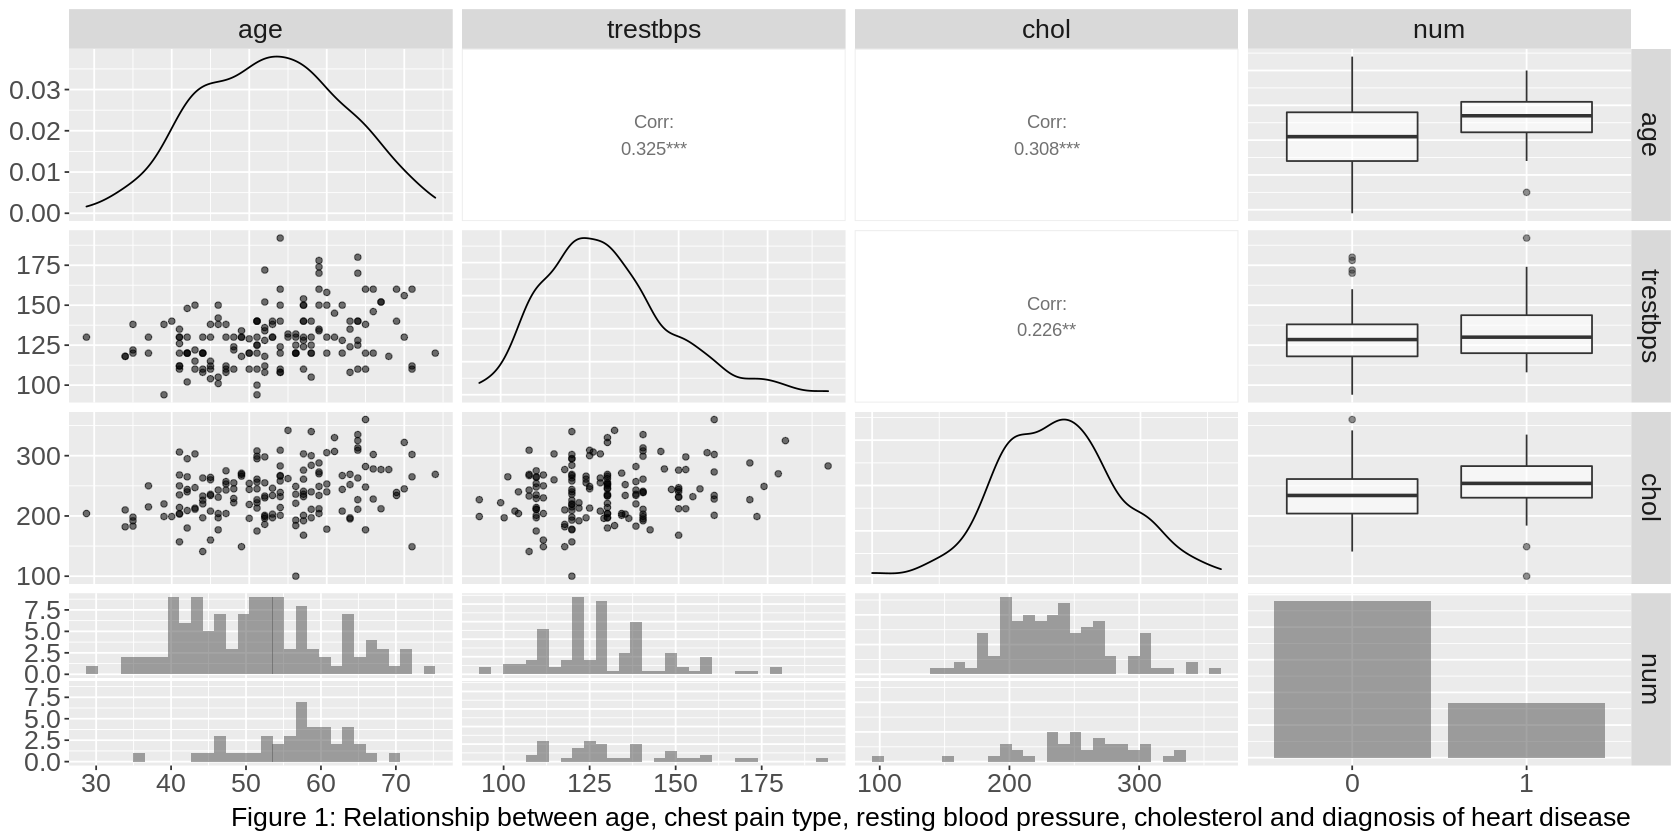

[1] "Table 6: Columns of predicted heart disease with test data"


.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
0,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
0,57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
0,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
0,48,0,3,130,275,0,0,139,0,0.2,1,0,3,0
1,58,0,1,150,283,1,2,162,0,1.0,1,0,3,0
0,66,0,1,150,226,0,0,114,0,2.6,3,0,3,0
0,42,1,4,140,226,0,0,178,0,0.0,1,0,3,0
0,61,1,3,150,243,1,0,137,1,1.0,2,0,3,0


[1] "Table 7: Accuracy of the prediction obtained is 70.4%"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.70370370
kap,binary,0.05263158


[1] "Table 8: Number of correctly predicted people with heart disease"


          Truth
Prediction  0  1
         0 36 12
         1  4  2

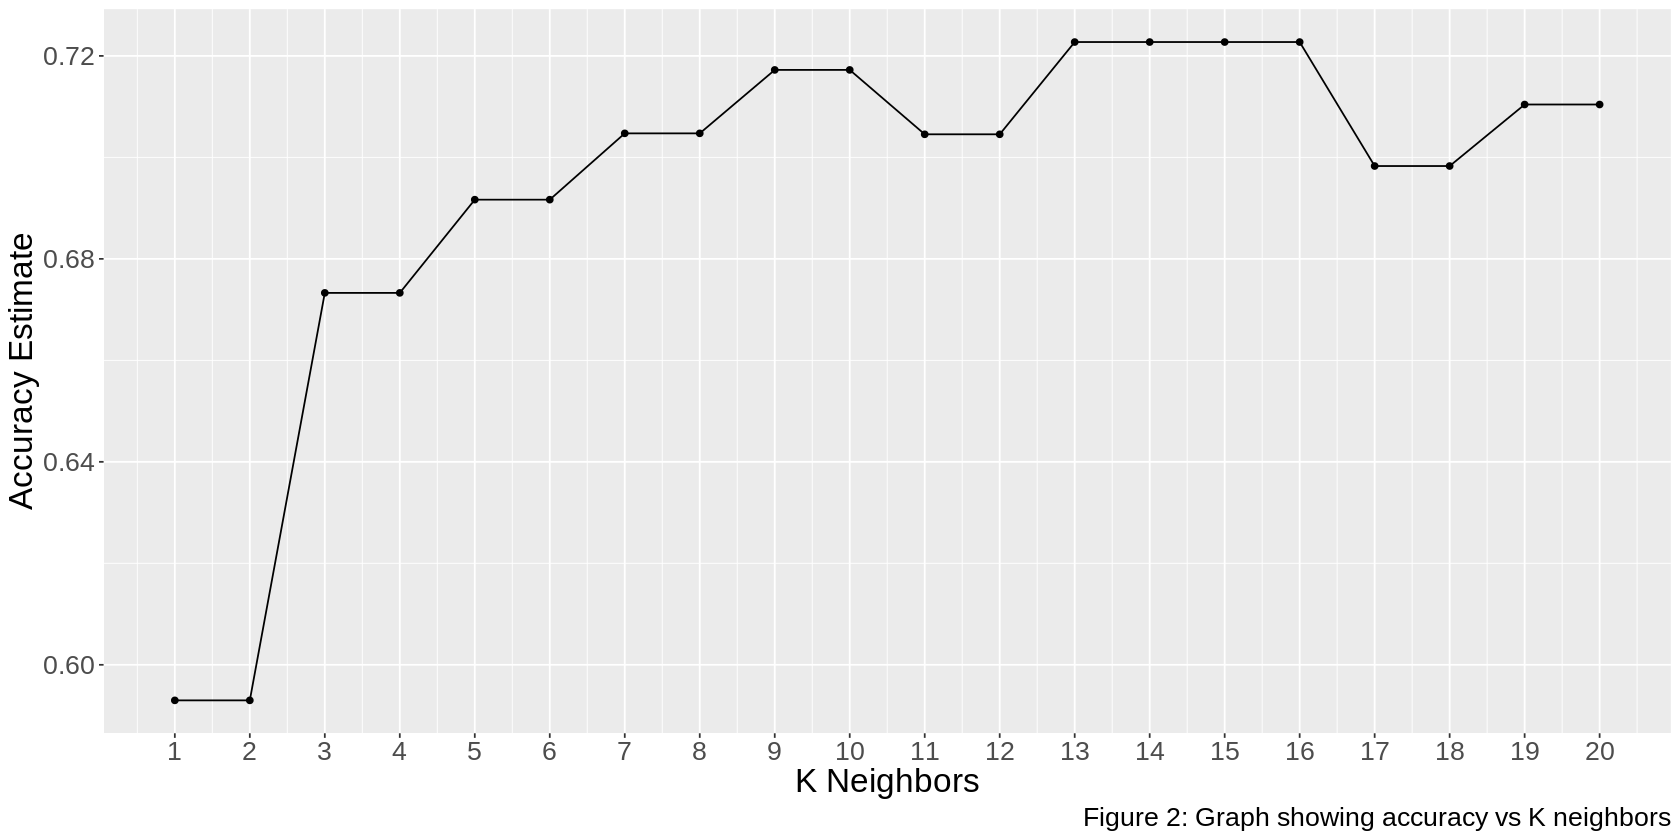

In [4]:
# Select and mutate to obtain a clean data frame, and only see variables we are insterested
database_train_selected <- database_train |>
                           mutate(num = as_factor(num)) |>
                           select(age, trestbps, chol, num) 

# Use ggpair to draw plots of relationship between variables
options(repr.plot.width = 14, repr.plot.height = 7)
graph <- database_train_selected |>
         ggpairs(mapping = aes(alpha = 0.4)) +
        labs(caption = "Figure 1: Relationship between age, chest pain type, resting blood pressure, cholesterol and diagnosis of heart disease") +
         theme(text = element_text(size = 20))
graph


# Setting up tuning specification and recipe
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_recipe <- recipe(num ~ ., data = database_train_selected) |>
     step_scale(all_predictors()) |>
     step_center(all_predictors())

# Setting up K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Setting up cross-validation (5 folds)
data_vfold <- vfold_cv(database_train_selected, v = 5, strata = num)

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

print("Table 5: K neighbors with their accuracy")
knn_results


# Plotting K-value vs Accuracy
k_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
          geom_point() +
          geom_line() +
          labs(x = "K Neighbors", y = "Accuracy Estimate", caption = "Figure 2: Graph showing accuracy vs K neighbors") +
          scale_x_continuous(breaks = seq(0, 20, by = 1)) +
         theme(text = element_text(size = 20))

k_plot

# Reset specification with best K value
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

# Adding recipe and specification into the workflow
knn_fit <- workflow() |>
           add_recipe(knn_recipe) |>
           add_model(knn_spec) |>
           fit(data = database_train_selected)

# Predict the testing set
prediction <- knn_fit |>
              predict(database_test) |>
              bind_cols(database_test) |>
              mutate(.pred_class = as_factor(.pred_class),
                     num = as_factor(num))

print("Table 6: Columns of predicted heart disease with test data")
prediction        


# Show the accuracy and confusion matrix
predict_metrics <- metrics(prediction, truth = num, estimate = .pred_class)
print("Table 7: Accuracy of the prediction obtained is 70.4%")
predict_metrics


predict_conf_mat <- conf_mat(prediction, truth = num, estimate = .pred_class)
print("Table 8: Number of correctly predicted people with heart disease")
predict_conf_mat



In [1]:
# Further plots relating to Chest Pain
options(repr.plot.width = 20, repr.plot.height = 7)

# Proportion of people with different chest pain type
cp_num_plot_true <- prediction |>
    ggplot(aes(x = as_factor(num), fill = as_factor(cp))) + 
    geom_bar(position = 'fill') +
    xlab('Diagnosis \n value 0: <50% diameter narrowing \n value 1: >50% diameter narrowing') +
    ylab('Proportion') +
    labs(fill = "Chest Pain Type \n Value 1: typical angina \n Value 2: atypical angina \n Value 3: non-anginal pain \n Value 4: asymptomatic", caption = "Figure 3: Number of males and females experiencing different chest pain types with respect to their heart disease diagnosis") +
    scale_fill_brewer(palette = "Set1") +
    theme(text = element_text(size = 12))

cp_num_plot_pred <- prediction |>
    ggplot(aes(x = as_factor(.pred_class), fill = as_factor(cp))) + 
    geom_bar(position = 'fill') +
    xlab('Diagnosis \n value 0: <50% diameter narrowing \n value 1: >50% diameter narrowing') +
    ylab('Proportion') +
    labs(fill = "Chest Pain Type \n Value 1: typical angina \n Value 2: atypical angina \n Value 3: non-anginal pain \n Value 4: asymptomatic") +
    scale_fill_brewer(palette = "Set1") 
plot_grid(cp_num_plot_true, cp_num_plot_pred, ncol = 2)

### Scatter plots of data relating variables that is used within the classifier

# Age vs trestbps

plot_1 <- database|>
            ggplot(aes(x=age,y=trestbps,color=num))+
            geom_point()+
            labs(title="Plot 1: Relationship between heart disease patients'\n age and resting blood pressure",
                 x="Patients' age",
                 y="Resting blood pressure (mmHg)",
                 color="Verification of heart disease patient",
                 caption = "Figure 3.1: Graph showing age vs resting blood pressure, the plot suggest a lack of relation for both cases of verification of heart disease")+
            theme(plot.title=element_text(size=20),
                 axis.title=element_text(size=15),
                 legend.title=element_text(size=15))

# Age vs chol

plot_2 <- database|>
            ggplot(aes(x=age,y=chol,color=num))+
            geom_point()+
            labs(title="Plot 2: Relationship between heart disease patients'\n age and cholestrol",
                x="Patients' age",
                y="Cholestrol (mg/dl)",
                color="Verification of heart disease patient",
                caption = "Figure 3.2: Graph showing age vs cholestrol, the plot suggest a weak positive relation for both cases of verification of heart disease")+
            theme(plot.title=element_text(size=20),
                 axis.title=element_text(size=15),
                 legend.title=element_text(size=15))

# trestbps vs chol

plot_3 <- database|>
            ggplot(aes(x=trestbps,y=chol,color=num))+
            geom_point()+
            labs(title="Plot 3: Relationship between heart disease patients'\n resting blood pressure and cholestrol",
                x="Resting blood pressure (mmHg)",
                y="Cholestrol (mg/dl)",
                color="Verification of heart disease patient",
                caption = "Figure 3.3: Graph showing age vs resting blood pressure, the plot suggest a weak positive relation for both cases of verification of heart disease")+
            theme(plot.title=element_text(size=20),
                 axis.title=element_text(size=15),
                 legend.title=element_text(size=15))

plot_1
plot_2
plot_3

ERROR: Error in ggplot(prediction, aes(x = as_factor(num), fill = as_factor(cp))): could not find function "ggplot"


### Results

**Report of Final Classifier**
- Table 7 shows that the classifier has an accuracy of 70.4% of predicting whether a person has heart disease.
- As shown in table 8, the classifier correctly predicted that 36 healthy people and 2 people with heart disease in the testing set.
- However, the classifier wrongly classified 12 people with heart disease as healthy people, and 4 healthy people as people with heart disease.

**Further Analysis with Plots**
- From figures 4 and 5, there is a poor correlation between age versus other variables (resting blood pressure and cholesterol).
- In figures 4 and 5, there is a higher number of people between the ages of 50 and 70 being diagnosed with heart disease. Hence as the age of people gets higher, they are more likely to get heart disease (which is a trend contributing to our classifier). 
- Two side by side bar plot (actual data on the left and prediction on the right) show that there are actually more patients (diagnosis = 1) who have no symptoms. 
- Conjecture: the classifier is not accurate enough probably because most people with heart disease have no symptoms, and a strong correlation cannot be concluded.

**Box and Whisker Plot (Figure 1)**
- From the box plots in figure 1, we can see that for the relationship between age and diagnosis of heart disease, Value 1: >50% diameter narrowing (num), the median is in the middle of the box and the whiskers are about the same on both sides. This means that the distribution is approximately symmetrical. Since the box is small, the spread is in turn smaller. The key takeaway is that as age increases, the risk of getting heart disease is also higher. 
- Between resting blood pressure (trestbps) and and diagnosis of heart disease, Value 1: >50% diameter narrowing (num), the median is closer to the bottom of the box and whisker is shorter on the lower end of the box, which indicates that the distribution is negatively skewed (skewed left). The box is also longer, which shows a larger spread. The main takeaway is that the higher a patient’s resting heart rate is, the higher the risk of getting heart disease.
- Between cholesterol (chol) and and diagnosis of heart disease, Value 1: >50% diameter narrowing (num), the median is in the the median is in the middle of the box and the whiskers are about the same on both sides, which shows us approximately symmetrical distribution. The smaller range indicates a small distribution and hence a smaller spread. We can conclude that the higher the cholesterol, the higher the risk of getting heart disease.
- It is also noted that the data that we got for patients diagnosed with heart disease (Value:1 >50% diameter narrowing) is about ⅓ of the patients compared to patients not diagnosed with heart disease (Value:0 <50% diameter narrowing). We thought that this might affect our prediction since we have significantly less data points for patients diagnosed with heart disease to begin with.


### Discussion

Our classifier predicts whether or not the patient has heart disease or not with 70.4% accuracy based on the patient’s age, cholesterol levels, and resting heart rate. In our proposal, we planned to include chest pain type in our classifier as it is also a relevant predictor variable but as we got to building the actual model we were unable to include a factor (categorical data) as a predictor, so we decided to omit it and use the remaining three predictors only. 

In our proposal, we were concerned that we would not be able to construct a classifier with high accuracy due to the limited number of variables and size of the dataset. For example, some of the variables that were not included in the database but we should also consider as contributors to heart disease include smoking, family history, physical inactivity, alcohol use and overweightness, with reference to the paper https://doi.org/10.3390/s221972274. Furthermore, we found poor correlation between the diagnosis and all other variables. In this case, it is somewhat aligned with the outcome we expected in our proposal.

Unfortunately due to the nature of the health industry, our classifier will most likely be unusable in real situations with the accuracy that we came up with. However, it potentially opens doors to help professionals better understand which factors are weighted heavier when it comes to heart disease.

Our project can lead into more complex models in the future taking into account larger datasets with more variables. We only selected a very small subset of potential predictors (as our dataset only had these variables available). However, other researchers/we should look for more significant predictor variables in the future given more time.

### References

1. Janosi, A., Steinbrunn, W,, Pfisterer, M., Detrano,R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X 

2. Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery. The American Journal of Cardiology, 64 (5), 304 - 310. https://doi.org/10.1016/0002-9149(89)90524-9

3. https://www.sciencedirect.com/science/article/pii/0002914989905249

4. Hassan C., Iqbal J, Irfan R, Hussain S, Algarni A., Bukhari S., Alturki N, Ullah S. (2022). Effectively Predicting the Presence of Coronary Heart Disease Using Machine Learning Classifiers. Sensors (Basel), 22(19), 7227. doi: 10.3390/s22197227